# Analyze data

After simulations are run using the `runner.py` script, the results will be stored in a .csv file. This notebook analyzes the data in this .csv file. Some code has been taken from the course notebooks.

In [1]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import combinations
from SALib.analyze import sobol
from SALib.sample import saltelli


## Loading and preprocessing

In [2]:
RESULTS_FILE = 'results_2022-02-02_09-35-24.csv'
CONFIG_FILE = 'config.json'

with open(CONFIG_FILE) as file:
    params = json.load(file)

problem = {
    'num_vars': len(params['variable_params']),
    'names': list(params['variable_params'].keys()),
    'bounds': list(params['variable_params'].values())
}

data = pd.read_csv(RESULTS_FILE)

data['Prey survives'] = data['Prey'] != 0
data['Predator survives'] = data['Predator'] != 0

mean_over_iterations = data.groupby(problem['names']).mean()

## Histogram
For most of our graphs will be using the survival rate as a measure. The survival rate is the rate of simulation where the species survive. Let's look at what common values are.

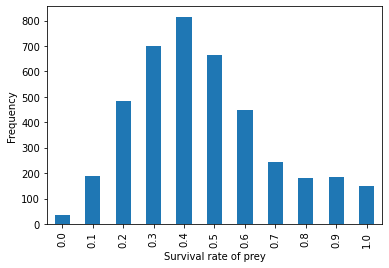

In [3]:
hist_data = mean_over_iterations['Prey survives'].value_counts().sort_index()
ax = hist_data.plot.bar()
plt.xlabel('Survival rate of prey')
plt.ylabel('Frequency')
plt.show()

## Sobol sensitivity analysis

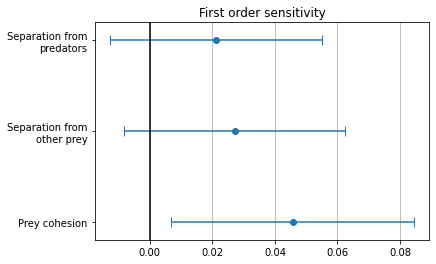

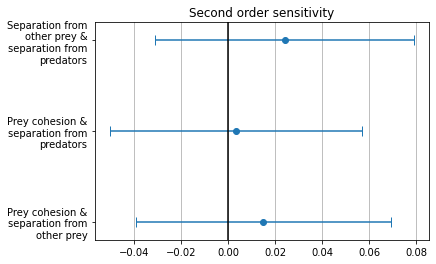

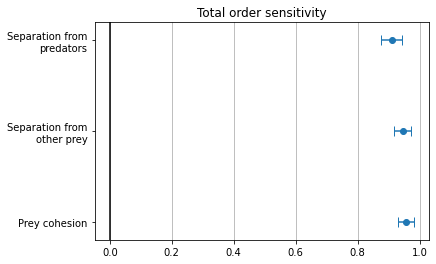

In [4]:
def plot_index(s, labels, i, title=''):
    """
    Creates a plot for Sobol sensitivity analysis that shows the contributions
    of each parameter to the global sensitivity.

    Args:
        s (dict): dictionary {'S#': dict, 'S#_conf': dict} of dicts that hold
            the values for a set of parameters
        params (list): the parameters taken from s
        i (str): string that indicates what order the sensitivity is.
        title (str): title for the plot
    """

    if i == '2':
        p = len(labels)
        combined_labels = list(combinations(labels, 2))
        labels = []
        
        for label_set in combined_labels:
            clean_label = ''
            for ind, label in enumerate(label_set):
                if ind == 0:
                    clean_label += f'{label} &\n'
                else:
                    clean_label += label[:1].lower() + label[1:]
            labels.append(clean_label)
                
        indices = s['S' + i].reshape((p ** 2))
        indices = indices[~np.isnan(indices)]
        errors = s['S' + i + '_conf'].reshape((p ** 2))
        errors = errors[~np.isnan(errors)]
    else:
        indices = s['S' + i]
        errors = s['S' + i + '_conf']
        plt.figure()

    l = len(indices)

    plt.title(title)
    plt.ylim([-0.2, len(indices) - 1 + 0.2])
    plt.yticks(range(l), labels)
    plt.errorbar(indices, range(l), xerr=errors, linestyle='None', marker='o', capsize=5.0)
    plt.grid(axis='x')
    plt.axvline(0, c='k')
    

def plot_sobol(column, iterations=10):
    si = sobol.analyze(problem, column.values)
    labels = ['Prey cohesion', 'Separation from\nother prey', 'Separation from\npredators']

    plot_index(si, labels, '1', 'First order sensitivity')
    plt.savefig('firstorder.png', dpi=300, bbox_inches="tight", pad_inches=0.2)
    plt.show()

    # Second order
    plot_index(si, labels, '2', 'Second order sensitivity')
    plt.savefig('secondorder.png', dpi=300, bbox_inches="tight", pad_inches=0.2)
    plt.show()

    # Total order
    plot_index(si, labels, 'T', 'Total order sensitivity')
    plt.savefig('totalorder.png', dpi=300, bbox_inches="tight", pad_inches=0.2)
    plt.show()

plot_sobol(data['Prey survives'])

## Effect of parameters on survival rate

Now we will plot each of the parameters against the survival rate of prey to see their effect. We use the same data as for the global sensitivity analysis. For each parameter we divide the runs in bins of 32.

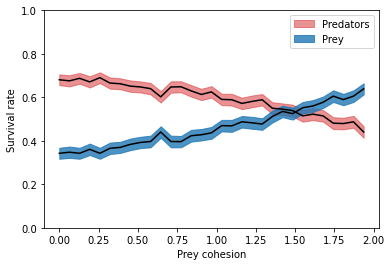

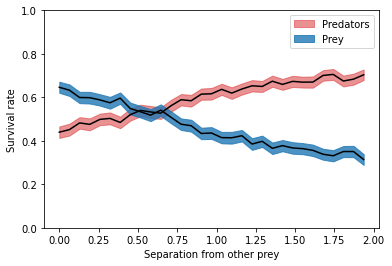

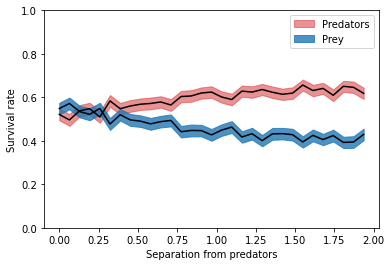

In [5]:
def plot_results(df, param, param_label, bins=64, lim=None):
    """
    Helper function for plot_all_vars. Plots the individual parameter vs
    variables passed.

    Args:
        ax: the axis to plot to
        df: dataframe that holds the data to be plotted
        var: variables to be taken from the dataframe
        param: which output variable to plot
    """
    df = df.copy()
    bins = np.linspace(0, 2, bins)
    df['bins'] = pd.cut(df[param], bins=bins)
    x = bins[:-1]
    y = df.groupby('bins').mean()['Prey survives']
    y2 = df.groupby('bins').mean()['Predator survives']

    replicates = df.groupby('bins')['Prey survives'].count()
    err = (1.96 * df.groupby('bins')['Prey survives'].std()) / np.sqrt(replicates)
    
    replicates2 = df.groupby('bins')['Predator survives'].count()
    err2 = (1.96 * df.groupby('bins')['Predator survives'].std()) / np.sqrt(replicates2)

    plt.plot(x, y2, c='k')
    plt.fill_between(x, y2 - err2, y2 + err2, color='tab:red', alpha=0.5, label='Predators')
    
    plt.plot(x, y, c='k')
    plt.fill_between(x, y - err, y + err, color='tab:blue', alpha=0.8, label='Prey')

    plt.xlabel(param_label)
    plt.ylabel('Survival rate')
    plt.legend()
    if lim:
        plt.ylim(*lim)
    plt.show()
    
plot_results(data, 'prey_cohere_factor', 'Prey cohesion', lim=(0,1), bins=32)
plot_results(data, 'prey_separate_factor', 'Separation from other prey', lim=(0,1), bins=32)
plot_results(data, 'prey_separate_predators_factor', 'Separation from predators', lim=(0,1), bins=32)